# Regression Assessment

Notebook to evaluate regression model performance using various metrics

@roman

7/4/2025

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import yaml

import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import libpysal as lps
from esda.moran import Moran
from splot.esda import moran_scatterplot, plot_moran
import h3

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 500)

---
# Settings

In [3]:
# Settings
# dir
DIR_DATA = '../../data'
DIR_RESULTS = '../../results'
DIR_MODELS = '../../models'
FILE_PROPERTIES = f"{DIR_DATA}/processed/properties_predicted_a81c87e6bb1a40fdbc4803b8ed3eb807.parquet"

# properties columns
COLS_PROPERTIES = [
 'observation_id',
 'half_bathrooms',
 'full_bathrooms',
 'neighborhood',
 'constructor',
 'zip_code',
 'age_in_months',
 'parking_lots',
 'valuation_date',
 'property_class_id',
 'controller_id',
 'elevator_service_id',
 'state_id',
 'municipality_id',
 'grantor_id',
 'property_type_id',
 'valuation_unit_id',
 'valuation_professional_id',
 'level',
 'total_levels',
 'bedrooms',
 'built_area',
 'saleable_area',
 'land_area',
 'conservation_status_id',
 'price',
 'market_price',
 'built_price',
 'land_price',
 'remaining_useful_life',
 'property_id',
 'city_cluster',
 'ppsm_comps',
 'distance_to_ocean',
 'ocean_label',
 'accessory_area',
 'ppsm_terrain',
 'hex_id',
 'longitude',
 'latitude',
 'y',
 'y_pred',
 'y_fitted',
 'y_pred_fitted',
 'set',
]

---
# Data & Model

## Data

In [4]:
# read parquet, index is observation_id
df_properties = pd.read_parquet(FILE_PROPERTIES, columns=COLS_PROPERTIES)

# set index
df_properties = df_properties.set_index('observation_id')

# look
print(df_properties.shape)
df_properties.head()

(1908483, 44)


,half_bathrooms,full_bathrooms,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,property_class_id,controller_id,elevator_service_id,state_id,municipality_id,grantor_id,property_type_id,valuation_unit_id,valuation_professional_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,conservation_status_id,price,market_price,built_price,land_price,remaining_useful_life,property_id,city_cluster,ppsm_comps,distance_to_ocean,ocean_label,accessory_area,ppsm_terrain,hex_id,longitude,latitude,y,y_pred,y_fitted,y_pred_fitted,set
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ac771cca-59a9-4c2d-81ac-f6091587bac3,0,1,LOMAS DE ZAPOPAN,NO APLICA,45130,56,1,2019-11-21,3,7b7e7c13-1454-47e7-a27e-5b569619598e,2,14,120,98013144-6a9f-4e08-9255-cb54568d2f5a,4,5735943b-99a4-4f76-a3d3-96194f0965c1,11ba1f99-422c-4e81-aa9c-a2407c039b8f,6,1,2,61,61,61,4,607000,607216,255327,254204,34,1a4af054-4dd6-5b71-8d5d-9a84cbbf85e4,11,9968,100000,no_ocean,0.000000,7207,8949ab4b233ffff,-103.399017,20.747696,9950.819672,9433.436523,-0.629089,-0.749726,train
11119915-2970-484b-81d2-ebeb6e35d933,0,1,BENITO JUAREZ,NO APLICA,88276,204,1,2019-11-26,3,d6d626a9-6dbe-4f1a-bf72-5a0c493bd291,2,28,027,98013144-6a9f-4e08-9255-cb54568d2f5a,2,caa0e4b2-ccc9-4b2a-8c42-6c5e89bb6511,685eb233-ffab-414d-a88a-4bc42419b9eb,3,1,2,53,70,102,4,508000,508245,273551,133314,43,8a051508-8d67-5f0b-b93a-f82c6665318c,58,8129,100000,no_ocean,17.139999,1717,894880da35bffff,-99.504822,27.440900,7257.142857,7560.211914,-1.342295,-1.249858,train
61ac2a5c-4cd6-4348-8742-6c6a29b9fb26,0,2,AGUILERA,NO APLICA,2900,12,1,2021-06-28,4,2a4e20d7-7ecd-4180-9ee2-5c826bcfa1f4,2,09,002,9a2781c9-b312-453c-86d1-a6e90584a083,4,7ffc29d8-5fe3-4c98-8570-5e5027bdd604,be25648c-da4b-427d-89cc-926786e33d69,6,1,2,66,66,22,6,2408000,2407798,825750,440838,69,df512e8a-db57-526e-8599-8c2ab0c75648,10,34590,100000,no_ocean,0.000000,22189,894995b8147ffff,-99.155601,19.473188,36484.848485,33727.996094,2.306354,2.128840,train
3d4b67fb-6035-4d00-8cb6-eab4e08cddea,0,1,JOYAS DE CUAUTITLAN,NO APLICA,54803,204,1,2020-07-21,3,e1420893-2e18-4b25-91bd-314d4907e290,2,15,024,98013144-6a9f-4e08-9255-cb54568d2f5a,3,73021b69-aafa-4d96-829a-17336ed08542,561af392-9164-41cd-8aee-fadef889ed22,3,2,2,55,55,52,4,794000,794000,361406,192441,43,aacd38f9-ecdb-5215-bf21-173325f50248,10,12069,100000,no_ocean,0.000000,4494,894995a8aa3ffff,-99.143413,19.681232,14436.363636,11887.272461,0.211605,-0.227346,train
b02b035c-efb0-4133-8c62-2a641949211c,0,2,MISION DE LORETO,NO APLICA,78399,204,1,2021-10-01,4,397871a6-a0a0-4181-bc1f-63f372378724,2,24,028,98013144-6a9f-4e08-9255-cb54568d2f5a,2,3f113aae-4e3e-420b-a018-cafeb215cf3a,0844fff5-461c-45eb-a940-e2f5bdf1940f,3,1,3,64,79,90,4,814000,814451,438690,298080,53,ce14726a-2243-5b0e-a9b0-6e2959cb7d67,18,10323,100000,no_ocean,15.000000,3091,89499dab027ffff,-100.933550,22.117405,10303.797468,11435.018555,-0.550334,-0.314983,train


---
# Regression Validation

In [5]:
def plot_predicted_vs_real(y, y_pred, q=99, sample_size=10_000):
    """
    Plot predicted vs real values, residuals, and percentual errors,
    showing only the best Q% of points (with lowest absolute residuals).
    
    Parameters:
    -----------
    y : array-like
        Real values
    y_pred : array-like
        Predicted values
    q : float, default=25
        Percentage of best points to display (with lowest absolute residuals)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the plots
    """
    # Convert inputs to numpy arrays if they're not
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    # Calculate residuals
    residuals = y - y_pred
    abs_residuals = np.abs(residuals)
    percentual_error = residuals / y
    
    # Create a dataframe for easier filtering
    df = pd.DataFrame({
        'y': y,
        'y_pred': y_pred,
        'residuals': residuals,
        'abs_residuals': abs_residuals,
        'percentual_error': percentual_error
    })
    
    # Filter to keep only the best Q% (lowest absolute residuals)
    threshold = np.percentile(abs_residuals, q)
    df_filtered = df[df['abs_residuals'] <= threshold]

    # get sample
    df_filtered = df_filtered.sample(
        n=min(sample_size, df_filtered.shape[0]),
        random_state=42
    )
    
    # Plot
    with plt.style.context(style='tableau-colorblind10'):
        fig, ax = plt.subplots(1, 3, figsize=(14, 6))
        
        # y pred vs y
        sns.scatterplot(x=df_filtered['y'], y=df_filtered['y_pred'], ax=ax[0])
        ax[0].set_title(f'Predicted vs Real (Best {q}%)')
        ax[0].set_xlabel('Real')
        ax[0].set_ylabel('Predicted')
        # Add identity line (using the full range of the original data for context)
        ax[0].plot([y.min(), y.max()], [y.min(), y.max()], color='gray', lw=2, linestyle='--')
        # Add regression line just for the filtered points
        sns.regplot(x=df_filtered['y'], y=df_filtered['y_pred'], ax=ax[0], scatter=False, color='red', lowess=True)
        ax[0].tick_params(axis='x', rotation=90)
        
        # Residuals
        sns.scatterplot(x=df_filtered['y'], y=df_filtered['residuals'], ax=ax[1])
        ax[1].set_title(f'Residuals vs Real (Best {q}%)')
        ax[1].set_xlabel('Real')
        ax[1].set_ylabel('Residuals')
        ax[1].axhline(0, color='gray', lw=2, linestyle='--')
        ax[1].tick_params(axis='x', rotation=90)
        # Add regression line just for the filtered points
        sns.regplot(x=df_filtered['y'], y=df_filtered['residuals'], ax=ax[1], scatter=False, color='red', lowess=True)
        # Add identity line (using the full range of the original data for context)
        ax[1].plot([y.min(), y.max()], [0, 0], color='gray', lw=2, linestyle='--')
        
        # Percentual error
        sns.scatterplot(x=df_filtered['y'], y=df_filtered['percentual_error'], ax=ax[2])
        ax[2].set_title(f'Percentual Error vs Real (Best {q}%)')
        ax[2].set_xlabel('Real')
        ax[2].set_ylabel('Percentual Error')
        ax[2].axhline(0, color='gray', lw=2, linestyle='--')
        ax[2].yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
        ax[2].tick_params(axis='x', rotation=90)
        
        plt.tight_layout()
        
    return fig


def plot_qq(y, y_pred, q=99, **kwargs):
    """
    Plot Q-Q plot of predicted vs real values, showing only the best Q% of points (with lowest absolute residuals).
    
    Parameters:
    -----------
    y : array-like
        Real values
    y_pred : array-like
        Predicted values
    q : float, default=99
        Percentage of best points to display (with lowest absolute residuals)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the Q-Q plot
    """
    # Convert inputs to numpy arrays if they're not
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    # Calculate residuals
    residuals = y - y_pred
    abs_residuals = np.abs(residuals)
    
    # Create a dataframe for easier filtering
    df = pd.DataFrame({
        'y': y,
        'y_pred': y_pred,
        'residuals': residuals,
        'abs_residuals': abs_residuals,
        'percentual_error': residuals / y
    })
    
    # Filter to keep only the best Q% (lowest absolute residuals)
    threshold = np.percentile(abs_residuals, q)
    df_filtered = df[df['abs_residuals'] <= threshold]
    
    # Plot Q-Q plot for filtered data
    fig, ax = plt.subplots(figsize=(8, 8))
    
    with plt.style.context(style='tableau-colorblind10'):
        sm.qqplot(
            df_filtered['residuals'],
            ax=ax,
            **kwargs
            )
        ax.set_title(f'Q-Q Plot (Best {q}%)')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        
        plt.tight_layout()
        
    return fig

## P1: Residual Analysis

### Train

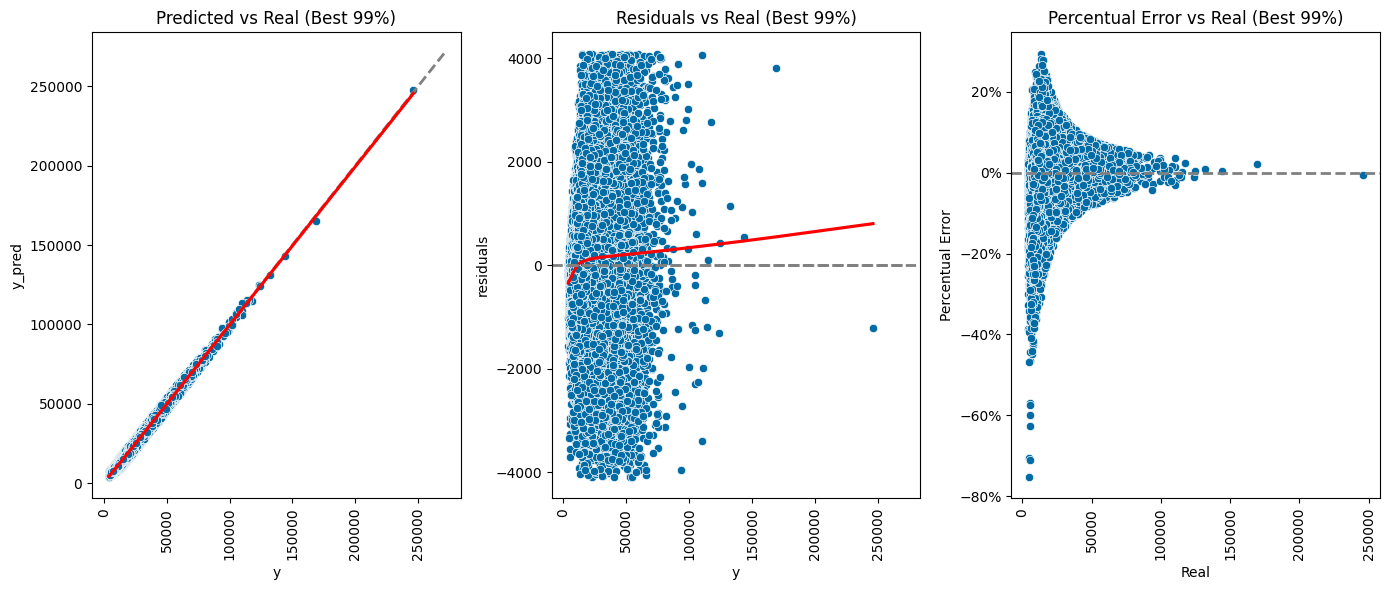

In [9]:
# plot predicted vs real for train set and real scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'train', 'y'],
    df_properties.loc[df_properties['set'] == 'train', 'y_pred'],
    q=99,
    sample_size=100_000
)

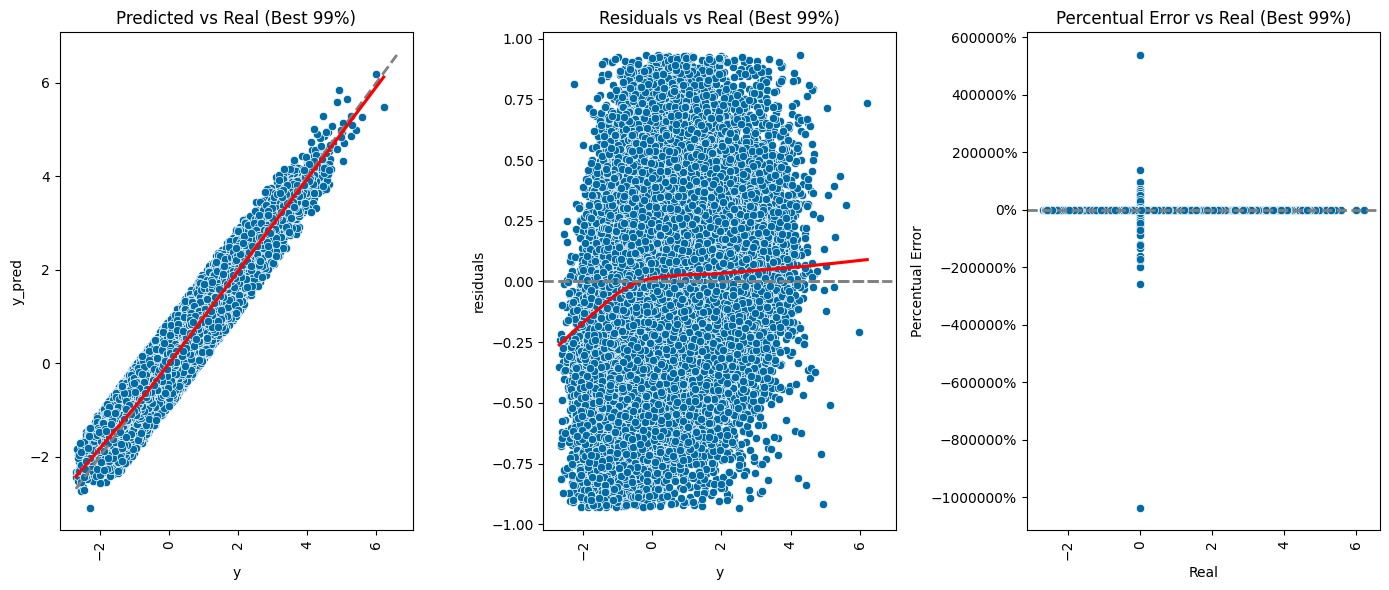

In [10]:
# plot predicted vs real for test set on fitted scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred_fitted'],
    q=99,
    sample_size=100_000
)

In [ ]:
# qq plot for train set in real scale
plot_qq(
    df_properties.loc[df_properties['set'] == 'train', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'train', 'y_pred_fitted'],
    q=100,
    line='s',
    fit=True
)

In [ ]:
# qq plot for train set in real scale
plot_qq(
    df_properties.loc[df_properties['set'] == 'train', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'train', 'y_pred_fitted'],
    q=99,
    line='s',
    fit=True
)

### Test

In [ ]:
# plot predicted vs real for test set on original scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred'],
    q=100,
    sample_size=np.inf
)

In [ ]:
# plot predicted vs real for test set on original scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred'],
    q=99,
    sample_size=np.inf
)

In [ ]:
# plot predicted vs real for test set on fitted scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred_fitted'],
    q=100,
    sample_size=np.inf
)

In [ ]:
# plot predicted vs real for test set on fitted scale
plot_predicted_vs_real(
    df_properties.loc[df_properties['set'] == 'test', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred_fitted'],
    q=99,
    sample_size=np.inf
)

In [ ]:
# qq plot for test set in real scale
plot_qq(
    df_properties.loc[df_properties['set'] == 'test', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred_fitted'],
    q=100,
    line='s',
    fit=True
)

In [ ]:
# qq plot for test set in real scale
plot_qq(
    df_properties.loc[df_properties['set'] == 'test', 'y_fitted'],
    df_properties.loc[df_properties['set'] == 'test', 'y_pred_fitted'],
    q=99,
    line='s',
    fit=True
)

## P2: Temporal Residuals

In [ ]:
# feature engineering    
df_properties = (
        df_properties
        .assign(
            # quarters since appraisal
            quarters_since_first_appraisal=lambda x: (
                x['valuation_date'] - x['valuation_date'].min()
                ).dt.days / (30.4 * 3),
            # recategorizations
            is_new=lambda x:
                np.where(x['age_in_months'].le(1), 'new', 'used'),
            conservacion_recat=lambda x:
                x['conservation_status_id'].replace({7: 3.5}).astype(int),
            is_renovated=lambda x:
                np.where(x['conservation_status_id'].ge(7), 'renovated', 'not_renovated'),
        )
        .assign(
            is_new=lambda x: x['is_new'].astype('category'),
        )
    )

In [ ]:
def plot_residuals_over_x(
        df, x_col, y_col, y_pred_col,
        sample_size=10_000, q=99, relative=True
        ):
    """
    Plot residuals over x to identify potential issues in the regression model adjustment.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data.
    x_col : str
        Column name representing numerical values (e.g., time).
    y_col : str
        Column name for the actual target values.
    y_pred_col : str
        Column name for the predicted target values.
    sample_size : int, default=10_000
        Number of points to sample for the plot.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the residuals plot.
    """
    # copy
    df = df.copy()

    # Calculate residuals
    df['residuals'] = df[y_col] - df[y_pred_col]

    # Percentual Residuals
    df['percentual_residuals'] = df['residuals'] / df[y_col]

    # Calculate absolute residuals
    df['abs_residuals'] = np.abs(df['residuals'])
    
    # Get the best Q% of points (with lowest absolute residuals)
    threshold = np.percentile(df['abs_residuals'], q)
    df = df[df['abs_residuals'] <= threshold]

    # Sample data for plotting
    df_sampled = df.sample(n=min(sample_size, len(df)), random_state=42)

    # Plot residuals over time
    with plt.style.context('tableau-colorblind10'):
        fig, ax = plt.subplots(figsize=(14, 6))
        if relative:
            sns.scatterplot(x=df_sampled[x_col], y=df_sampled['percentual_residuals'], ax=ax)
            # Add regression line
            sns.regplot(x=df_sampled[x_col], y=df_sampled['percentual_residuals'], ax=ax, scatter=False, color='red')
            ax.set_ylabel('Residuals (%)')
            ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
        else:
            sns.scatterplot(x=df_sampled[x_col], y=df_sampled['residuals'], ax=ax)
            # Add regression line
            sns.regplot(x=df_sampled[x_col], y=df_sampled['residuals'], ax=ax, scatter=False, color='red', lowess=True)
            ax.set_ylabel('Residuals')
        ax.set_xlabel(x_col)
        ax.set_title(f'Residuals vs {x_col} (Best {q}%)')
        ax.axhline(0, color='gray', lw=2, linestyle='--')
        ax.tick_params(axis='x', rotation=90)
        plt.tight_layout()
    return fig


def plot_residuals_categorical(
        df, x_col, y_col, y_pred_col,
        sample_size=10_000, q=99, relative=True,
        **kwargs
        ):
    """
    Plot residuals over categorical variable to identify potential issues in the regression model adjustment.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data.
    x_col : str
        Column name representing categorical values (e.g., time).
    y_col : str
        Column name for the actual target values.
    y_pred_col : str
        Column name for the predicted target values.
    sample_size : int, default=10_000
        Number of points to sample for the plot.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the residuals plot.
    """
    # copy
    df = df.copy()

    # Calculate residuals
    df['residuals'] = df[y_col] - df[y_pred_col]

    # Percentual Residuals
    df['percentual_residuals'] = df['residuals'] / df[y_col]

    # Calculate absolute residuals
    df['abs_residuals'] = np.abs(df['residuals'])
    
    # Get the best Q% of points (with lowest absolute residuals)
    threshold = np.percentile(df['abs_residuals'], q)
    df = df[df['abs_residuals'] <= threshold]

    # Sample data for plotting
    df_sampled = df.sample(n=min(sample_size, len(df)), random_state=42)

    # order by x_col
    df_sampled[x_col] = pd.Categorical(df_sampled[x_col], ordered=True)
    df_sampled = df_sampled.sort_values(x_col, ascending=True, ignore_index=True)

    # Plot residuals over time
    with plt.style.context('tableau-colorblind10'):
        fig, ax = plt.subplots(figsize=(14, 6))
        if relative:
            sns.boxplot(data=df_sampled, x=x_col, y='percentual_residuals', ax=ax, **kwargs)
            ax.set_ylabel('Residuals (%)')
            ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
        else:
            sns.boxplot(data=df_sampled, x=x_col, y='residuals',ax=ax, **kwargs)
            ax.set_ylabel('Residuals')
        ax.set_xlabel(x_col)
        ax.set_title(f'Residuals vs {x_col} (Best {q}%)')
        ax.axhline(0, color='gray', lw=2, linestyle='--')
        ax.tick_params
        ax.tick_params(axis='x', rotation=90)
        plt.tight_layout()
    return fig



In [ ]:
# cols to test
cols_to_test = [
    # in regression
    'quarters_since_first_appraisal',
    'saleable_area',
    'land_area',
    'full_bathrooms',
    'half_bathrooms',
    'parking_lots',
    'remaining_useful_life',
    # not in regression
    'age_in_months',
    'level',
    # 'total_levels',
    'bedrooms',
    'built_area',
    'accessory_area',
]


# plot residuals over x
for x in cols_to_test:
    print(f"Plotting residuals over {x}...")
    display(plot_residuals_over_x(
        df_properties.loc[df_properties['set'] == 'test'],
        x_col=x,
        y_col='y',
        y_pred_col='y_pred',
        sample_size=np.inf,
        q=99,
        relative=True
    ))

In [ ]:
# cols to test
cols_to_test = [
    # in regression
    'property_type_id',
    # out of regression
    'state_id',
    'conservation_status_id',
    'bedrooms',
    'elevator_service_id',
    'distance_to_ocean',
    'ocean_label',
    'conservacion_recat',
    'is_renovated',
    'is_new'
]

# plot residuals over categorical
for x in cols_to_test:
    print(f"Plotting residuals over {x}...")
    display(plot_residuals_categorical(
        df_properties.loc[df_properties['set'] == 'test'],
        x_col=x,
        y_col='y',
        y_pred_col='y_pred',
        sample_size=np.inf,
        q=100,
        relative=True,
        showfliers=False,
        palette='Set2',
        hue=x,
    ))

## S3: Geospatial analysis

In [ ]:
# hex bin analysis
df_hex_residuals = (
    df_properties
    .assign(
        residuals=lambda x: x['y'] - x['y_pred'],
        percentual_residuals=lambda x: x['residuals'] / x['y']
    )
    .loc[
        lambda x: x['set'] == 'test',:
    ]
    .groupby('hex_id')
    .agg({
        'residuals': ['mean', 'std'],
        'percentual_residuals': ['mean', 'std', 'count'],
    })
)

# columns
df_hex_residuals.columns = [
    '_'.join(col).strip() if col[1] else col[0]
    for col in df_hex_residuals.columns
]


# look
print(df_hex_residuals.shape)
df_hex_residuals.head()

---
# Sandbox

In [ ]:
df_properties.columns

In [ ]:
type(pools[label]['y'])

In [ ]:
# see preds
pools['train'].keys()

In [ ]:
pools['train']['y_original']

In [ ]:
transformer.get_transformers()['target'].scale_

In [ ]:
transformer.get_transformers()['target'].mean_

In [ ]:
np.exp(0.44260513 * pools['train']['y'] + 9.48384826)

In [ ]:
pools['train']['y']

In [ ]:
pools['train']['X']

In [ ]:
pools['train']['X'].columns

In [ ]:
# look
pools['train']['X'].head(5)

In [ ]:
%whos

In [ ]:
# columns
df_properties.columns.to_list()